In [ ]:
from google.colab import files
uploaded = files.upload()


Saving DENV4.fasta to DENV4.fasta
Saving DENV1.fasta to DENV1.fasta
Saving DENV2.fasta to DENV2.fasta
Saving DENV3.fasta to DENV3.fasta


In [ ]:
import os
print(os.listdir('/content'))


['.config', 'DENV4.fasta', 'DENV3.fasta', 'DENV1.fasta', 'DENV2.fasta', 'sample_data']


In [ ]:
!pip install biopython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.6 MB/s eta 0:00:00


In [ ]:
import os
from Bio import SeqIO
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Set folder path
folder_path = "/content"

# Label mapping
label_map = {
    "DENV1": 0,
    "DENV2": 1,
    "DENV3": 2,
    "DENV4": 3,
}

# Extract sequences and labels
data = []
for file in os.listdir(folder_path):
    if file.endswith(".fasta") or file.endswith(".fa"):
        for serotype in label_map:
            if serotype in file.upper():
                label = label_map[serotype]
                break
        else:
            continue

        filepath = os.path.join(folder_path, file)
        for record in SeqIO.parse(filepath, "fasta"):
            sequence = str(record.seq).upper()
            data.append([sequence, label])

# Create DataFrame
df = pd.DataFrame(data, columns=["sequence", "label"])
print("Sample data:")
print(df.head())
print(f"Total samples: {len(df)}")


Sample data:
                                            sequence  label
0  ATGAACCAACGAAAAAAGGTGGTTAAACCACCTTTCAATATGCTGA...      3
1  ATGAACCAACGAAAAAAGGTGGTTAGACCACCTTTCAATATGCTGA...      3
2  ATGAACCAACGAAAAAAGGTGGTTAGACCACCTTTCAATATGCTGA...      3
3  ATGAACCAACGAAAAAAGGTGGTTAGACCACCTTTCAATATGCTGA...      3
4  ATGAACCAACGAAAAAAGGTGGTTAGACCACCTTTCAATATGCTGA...      3
Total samples: 5992


In [ ]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Manually build the model using the correct input shape
model.build(input_shape=(None, max_len))  # None=batch size, max_len=sequence length
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 1000, 128)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,468 (212.77 KB)

 Trainable params: 54,468 (212.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Convert DNA sequence to numeric encoding
def encode_sequence(seq):
    mapping = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
    return [mapping.get(base, 0) for base in seq]

# Apply encoding
df['encoded'] = df['sequence'].apply(encode_sequence)

# Pad sequences to uniform length
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LEN = 1000  # or any value suitable to your average sequence length
X = pad_sequences(df['encoded'], maxlen=MAX_LEN, padding='post')

# Labels
y = df['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Now train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6183 - loss: 1.0721 - val_accuracy: 0.9291 - val_loss: 0.2177
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9354 - loss: 0.1740 - val_accuracy: 0.9812 - val_loss: 0.0740
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9820 - loss: 0.0465 - val_accuracy: 0.9917 - val_loss: 0.0259
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9889 - loss: 0.0226 - val_accuracy: 0.9781 - val_loss: 0.0635
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9809 - loss: 0.0450 - val_accuracy: 0.9937 - val_loss: 0.0220


In [ ]:
from sklearn.metrics import classification_report

# Predict class probabilities on test data
y_pred_probs = model.predict(X_test)

# Convert to class labels
y_pred = y_pred_probs.argmax(axis=1)

# Classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.9791    0.9979    0.9884       470
           1     0.9946    0.9761    0.9852       376
           2     0.9922    0.9922    0.9922       255
           3     1.0000    0.9796    0.9897        98

    accuracy                         0.9883      1199
   macro avg     0.9915    0.9864    0.9889      1199
weighted avg     0.9884    0.9883    0.9883      1199



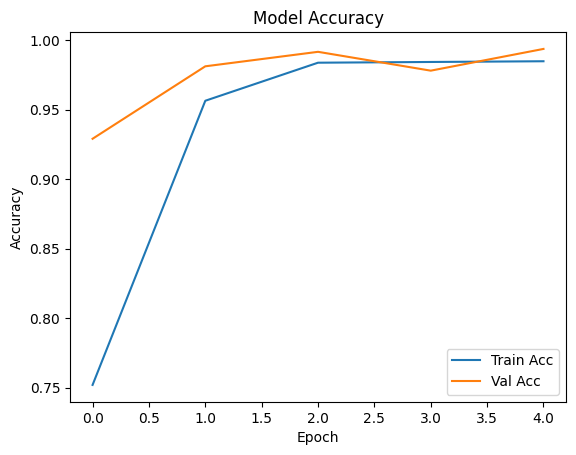

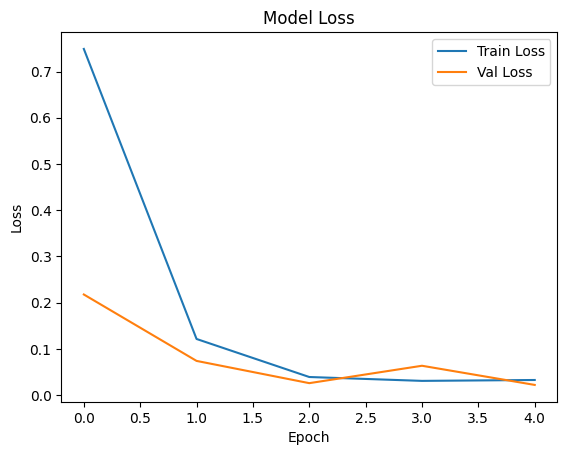

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


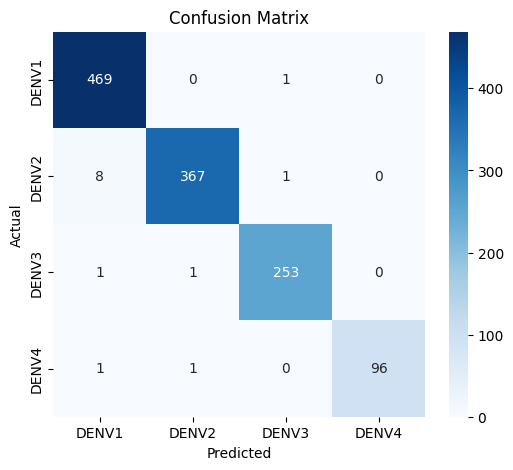

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['DENV1', 'DENV2', 'DENV3', 'DENV4'], yticklabels=['DENV1', 'DENV2', 'DENV3', 'DENV4'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
FNN(Feed Forward Neural Network)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 256)            │       173,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,724 (838.77 KB)

 Trainable params: 214,724 (838.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3423 - loss: 29.9346 - val_accuracy: 0.9187 - val_loss: 0.7983
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5939 - loss: 1.1803 - val_accuracy: 0.9228 - val_loss: 0.5812
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6782 - loss: 0.7803 - val_accuracy: 0.9291 - val_loss: 0.5106
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6439 - loss: 0.9120 - val_accuracy: 0.9281 - val_loss: 0.5027
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6439 - loss: 0.8881 - val_accuracy: 0.8394 - val_loss: 0.5217
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       470
           1       0.72      0.99      0.84       376
           2       0.91      0.47      0.62       255
           3       0.00      0.00      0.00        98

    accuracy                         

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


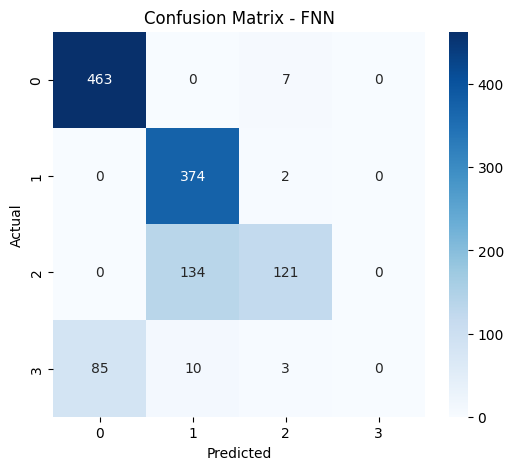

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is already loaded in a DataFrame
# df = pd.read_csv("your_data.csv") or use the existing df

# ----- Step 1: K-mer Encoding -----
def get_kmers(sequence, k=3):
    return ' '.join([sequence[i:i+k] for i in range(len(sequence)-k+1)])

df['kmers'] = df['sequence'].apply(lambda x: get_kmers(x, k=3))

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['kmers']).toarray()

# ----- Step 2: Label Encoding -----
le = LabelEncoder()
y = le.fit_transform(df['label'])
y_cat = to_categorical(y)

# ----- Step 3: Train-Test Split -----
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# ----- Step 4: FNN Model -----
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ----- Step 5: Train -----
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# ----- Step 6: Evaluate -----
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Classification Report
print("\nClassification Report:\n")
target_names = [str(cls) for cls in le.classes_]
print(classification_report(y_true, y_pred_classes, target_names=target_names))


# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - FNN')
plt.show()


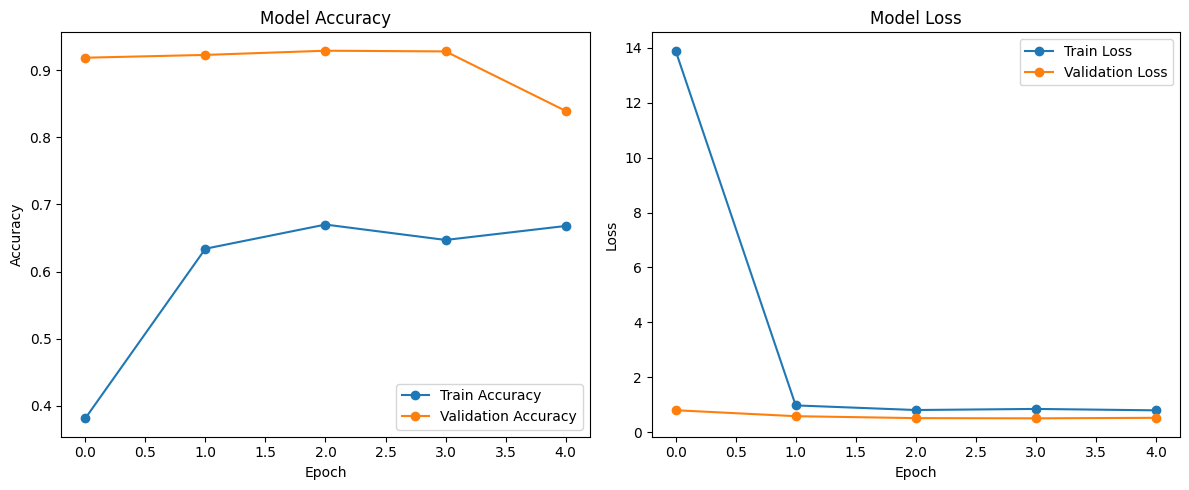

In [30]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


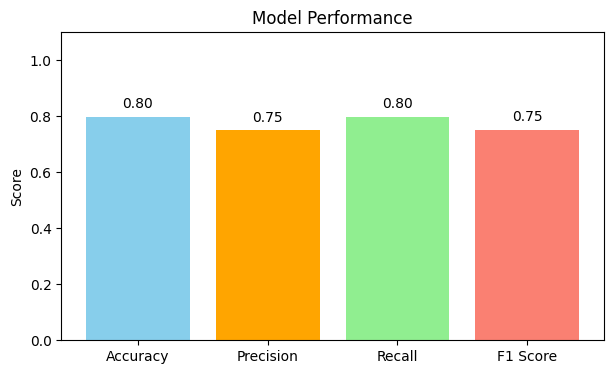

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Step 2: Put them in lists
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]

# Step 3: Plot the bar graph
plt.figure(figsize=(7, 4))
bars = plt.bar(metrics, scores, color=['skyblue', 'orange', 'lightgreen', 'salmon'])
plt.ylim(0, 1.1)
plt.title('Model Performance')
plt.ylabel('Score')

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.03, f'{height:.2f}', ha='center')

plt.grid(False)  # remove grid
plt.show()


In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))  # More neurons
model.add(Dropout(0.4))  # Higher dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Adjust according to your class count

optimizer = Adam(learning_rate=0.0005)  # Slower learning to improve generalization
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3604 - loss: 14.4780 - val_accuracy: 0.9864 - val_loss: 0.1766
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9082 - loss: 0.3992 - val_accuracy: 0.9906 - val_loss: 0.0842
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9797 - loss: 0.1455 - val_accuracy: 0.9948 - val_loss: 0.0404
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9883 - loss: 0.1472 - val_accuracy: 0.9937 - val_loss: 0.0543
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9853 - loss: 0.0823 - val_accuracy: 0.9937 - val_loss: 0.0362
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9900 - loss: 0.0761 - val_accuracy: 0.9969 - val_loss: 0.0806
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9933 - loss: 0.0548 - val_accuracy: 0.9958 - val_loss: 0.0771
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9888 - loss: 0.0671 - val_accuracy: 0.9969 - val_loss: 0.0351

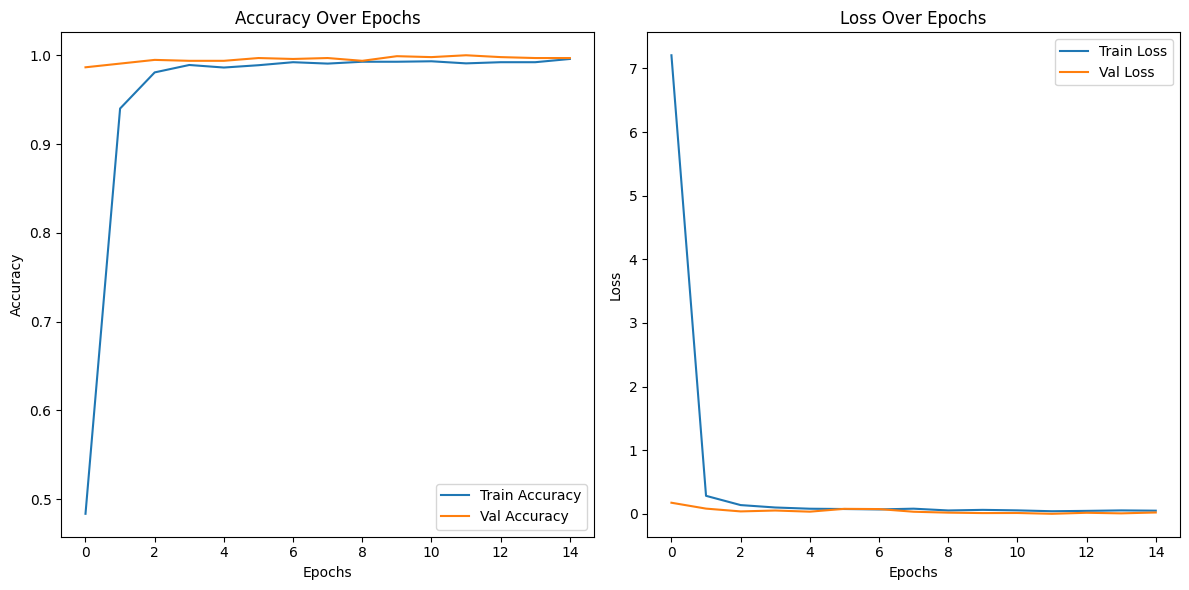

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:

[0 1 2 3]

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       470
           1       0.99      1.00      0.99       376
           2       1.00      0.99      0.99       255
           3       1.00      0.97      0.98        98

    accuracy                           0.99      1199
   macro avg       1.00      0.99      0.99      1199
weighted avg       1.00      0.99      0.99      1199



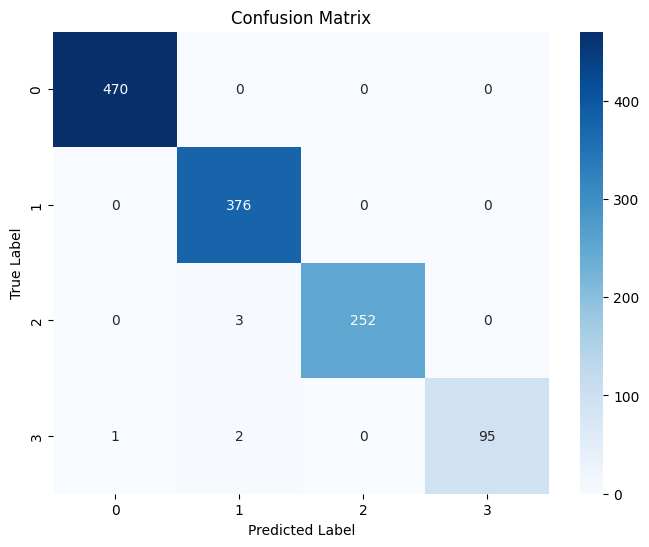

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Assuming X and y are already defined, where:
# X is your feature data (sequences encoded as integers)
# y is your target labels (integers representing the classes)

# Example of loading your data (replace with your actual dataset loading process)
# X = np.array(...) # Your features
# y = np.array(...) # Your target labels

# Label encode the target variable if it's not already integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # This will convert labels into integers

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the FFNN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dropout(0.2))  # Dropout layer to reduce overfitting
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(4, activation='softmax'))  # Output layer (4 classes, softmax for classification)

# Compile the model with Sparse Categorical Cross-Entropy loss
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=15,
                    batch_size=64,
                    verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# You can plot the accuracy and loss graphs from history
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Classification Report
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("\nClassification Report:\n")
# Ensure the label encoder has been fitted properly
print(label_encoder.classes_)

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=[str(i) for i in label_encoder.classes_]))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

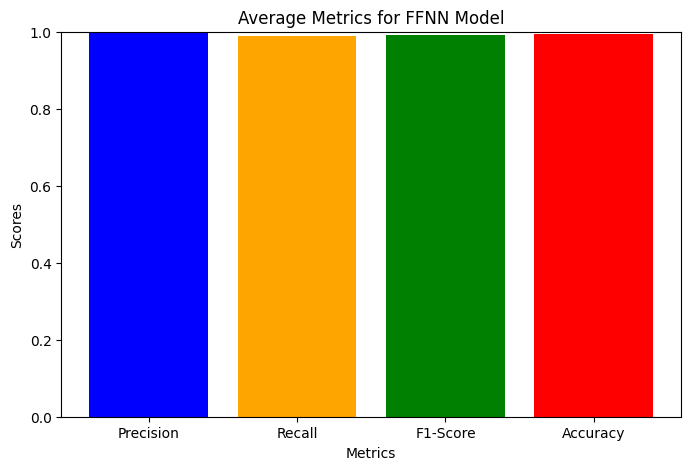

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Predict the classes for the test set
y_pred_classes = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_classes, axis=1)  # In case of multi-class classification

# Compute the classification report
report = classification_report(y_test, y_pred_classes, output_dict=True)

# Extracting the metrics for macro avg (average across classes)
avg_precision = report['macro avg']['precision']
avg_recall = report['macro avg']['recall']
avg_f1_score = report['macro avg']['f1-score']
avg_accuracy = accuracy_score(y_test, y_pred_classes)

# Create a list of metrics and corresponding values
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
values = [avg_precision, avg_recall, avg_f1_score, avg_accuracy]

# Plotting the bar graph
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis from 0 to 1 for better comparison

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Average Metrics for FFNN Model')
plt.show


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


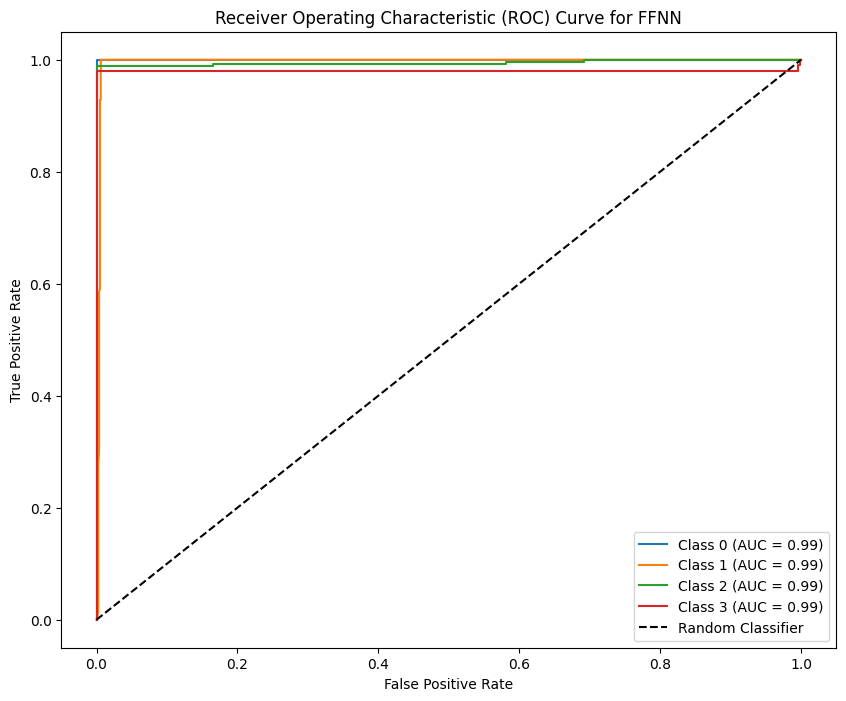

Overall ROC AUC Score (macro average): 0.99


In [42]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

# One-hot encode the true labels (y_test) for multi-class classification
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Get the predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Calculate the ROC AUC score for each class (you can use "macro" for average score across classes)
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 8))

# Compute ROC curve for each class
for i in range(y_pred_prob.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal (chance level)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for FFNN')
plt.legend(loc="lower right")
plt.show()

# Print the overall ROC AUC score
print(f"Overall ROC AUC Score (macro average): {roc_auc:.2f}")
